# Project Outline

1. Dataset introduction
   1. No. of stocks
   2. Information on each stock
2. Motivation of a prediction problem
   1. Plot to visualize stock and motivations
3. Problem definition + Models
   1. Output
      1. Regression
      2. Classification
   2. Input
      1. Raw, one
      2. Engineered, one
      3. Summarized, all
   3. State of the art
      1. LSTM, due to the time series nature.
   4. CS3244
      1. kNN, DT, SVM, linear model, logistic regression
4. Discuss the models, one at a time.
   1. Naive implementation
   2. Iterative improvments
   3. Inference of the results
      1. Selected features?
      2. Good/bad?
      3. Future works?
5. Conclusions
   1. Is regression better than classification?
   2. Does using other stock actually help?
   3. Are the technical indicators used by other people actually meaningful?
   4. What are the future directions for this project?

# Obtaining dataset locally and removing small stocks

We install the kaggle package, get the dataset and remove the duplicates. Note that these commands are common to **Linux** and so it is necessary to execute them in a Linux shell.

Preliminary test suggests that there are some stocks that have empty or small amounts of data which is not helpful if we were to build a model using them. We have *arbitrarily* decided to exclude all files less than 7000 bytes (approximately 150 days).

In [71]:
# Get the kaggle package and dataset
# ! pip install kaggle
# ! kaggle datasets download -d borismarjanovic/price-volume-data-for-all-us-stocks-etfs

# One liner -- adjust threshold. For reference, each line is 1 day:
# 4000 bytes ~ 90 lines; 5000 bytes ~ 110 lines; 7000 bytes ~ 150 lines
# ! unzip -nqq price-volume-data-for-all-us-stocks-etfs.zip && rm -rf ETFs Stocks sample_data/ && find Data/**/* -size -7000c -delete

# Some useful commands
# The above but separately
# ! unzip -nqq price-volume-data-for-all-us-stocks-etfs.zip
# ! rm -rf ETFs Stocks
# ! find Data/**/* -size -7000c -delete

# Other information
# ! ls -lSh Data/* # List out all files inside both Data/Stocks and Data/ETFs, sorted descending size
# ! ls -l Data/Stocks | wc -l             # Count number of files in Stocks
# ! find Data/Stocks -size -2000c -print  # List all files in Data/Stocks less than 2000 bytes
# ! find Data/* -size -2000c -delete      # Delete all files in Data/* less than 2000 bytes
# ! cat Data/Stocks/btu.us.txt | wc -l    # Count number of lines in btu.us.txt

# Basic understanding of dataset

We are given information for both stocks and ETFs, and each stock or ETF is a time series data containing the same fixed columns. In this section, we develop a basic understanding of the dataset that we are dealing with, via basic features and summary statistics.


In [72]:
# Importing of packages
# Basic data processing and visualization libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Training and evaluation
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error, r2_score, ConfusionMatrixDisplay

# LSTM

# Decision Tree

# k-NN

# Linear and Logistic Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# SVM

In [73]:
# How many stocks/ETFs are there?
# 8539 Total stocks in total as compared to those being removed 7540 (Around 1000 stocks has been dropped)
stocks = glob.glob("Data/Stocks/*.txt")
etfs = glob.glob("Data/ETFs/*.txt")
combined = stocks + etfs
print(f"Number of stocks: {len(stocks)}")
print(f"Number of ETFs: {len(etfs)}")

# # Plot a histogram of file sizes for each dataset in a single overlapping figure
# stocks_sizes = [os.path.getsize(file) / 1000 for file in stocks]
# etfs_sizes = [os.path.getsize(file) / 1000 for file in etfs]

# plt.hist(stocks_sizes, alpha=0.5, label="Stocks")
# plt.hist(etfs_sizes, alpha=0.5, label="ETFs")
# plt.xlabel("File size (kB)")
# plt.ylabel("Frequency")
# plt.legend()

# # Save figure and show
# ! mkdir -p plots  # Create directory if it doesn't exist
# plt.title("Distribution of file sizes")
# plt.tight_layout()
# plt.savefig("plots/file_sizes.png")
# plt.show()

Number of stocks: 6428
Number of ETFs: 1311


It is clear that there are a lot more stocks than ETFs, and that the distribution of sizes is skewed towards the right for the stocks (i.e. there are some stocks with extremely large file sizes). For simplicity, we *arbitrarily* choose to only consider stocks. Given the 6428 stocks, how does the data for each individual stock look like? Is it clean? We establish some basic file reading processes for a single stock.

In [74]:
def read_file_data(file_path: str, verbose: bool = False) -> pd.DataFrame:
    """
    Reads the given file path into a pandas dataframe, checks that there are no NA values and returns the df

    Parameters
    ----------
    file_path : str
        The path to the file to be read
    verbose : bool, optional
        Whether to print the dataframe summary, by default False

    Returns
    -------
    pd.DataFrame
        The dataframe read from the file
    """
    df = pd.read_csv(file_path)
    df["Date"] = pd.to_datetime(df["Date"])

    # Identify all columns where all values are the same
    irrelevant = df.columns[df.min() == df.max()]
    if verbose:
        if len(irrelevant) == 0:
            print("No irrelevant columns")
        else:
            print(f"Irrelevant columns, min = max: {irrelevant}")

    # Drop all columns where all values are the same
    df = df.loc[:, df.min() != df.max()]

    if verbose:
        display(df.describe())

    # Ensure that there are no null values
    file_name = file_path.split("/")[-1]
    if df.isna().any().any():
        print(f"{file_name} contains null values")

    # Ensure that the columns are as expected
    if (df.columns != ["Date", "Open", "High", "Low", "Close", "Volume"]).any():
        print(f"{file_name} contains unexpected columns")
    return df


# Work on this stock for all single stock prediction
df = read_file_data(stocks[0], verbose=True)

# Check on everything to ensure no null values for all datasets
# for file in combined:
#     read_file_data(file)

Irrelevant columns, min = max: Index(['OpenInt'], dtype='object')


,Date,Open,High,Low,Close,Volume
count,4521,4521.000000,4521.000000,4521.000000,4521.000000,4.521000e+03
mean,2008-11-19 16:31:31.970802944,27.856296,28.270442,27.452486,27.871357,3.993503e+06
min,1999-11-18 00:00:00,7.223100,7.513900,7.087800,7.323800,0.000000e+00
25%,2004-05-26 00:00:00,19.117000,19.435000,18.780000,19.089000,2.407862e+06
50%,2008-11-19 00:00:00,24.456000,24.809000,24.159000,24.490000,3.460621e+06
75%,2013-05-20 00:00:00,36.502000,37.046000,35.877000,36.521000,4.849809e+06
max,2017-11-10 00:00:00,105.300000,109.370000,97.881000,107.320000,6.627751e+07
std,NaN,12.940880,13.176000,12.711735,12.944389,2.665730e+06


For every file, OpenInt is not a meaningful feature as the minimum and the maximum are always equal, and we end up with the following five basic information for each weekday: Open, High, Low, Close, Volume. We can compactly plot such information as a candlestick chart.

While we can choose any duration of the data to plot, for a clear illustration, we will show the last 13 weeks, which is about a quarter of a year.

In [75]:
def visualize_stock_full(df: pd.DataFrame, save_path: str = None) -> None:
    """
    Plots the last 13 weeks of a given dataframe as a candlestick chart

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to be plotted
    save_path : str, optional
        The path to save the figure, by default None
    """
    df = df[-13 * 5 :]

    # Dynamic figure width based on number of rows
    fig_width = max(10, len(df) // 8)  # Minimum width is 10, scaling with data

    # 2 subplots vertically stacked in 4:1 ratio
    # Top is for the candlestick chart, bottom is for the volume
    _, ax = plt.subplots(
        2, 1, figsize=(fig_width, 8), sharex=True, height_ratios=[4, 1]
    )

    # Color scheme for up/down days
    df["Color"] = np.where(df["Close"] >= df["Open"], "green", "red")

    # Plot candlesticks
    for _, row in df.iterrows():
        # 1. High-Low line
        ax[0].plot(
            [row["Date"], row["Date"]],
            [row["Low"], row["High"]],
            color=row["Color"],
            zorder=1,
        )

        # 2. Open-Close rectangle, above the high-low line
        ax[0].bar(
            row["Date"],
            height=row["Close"] - row["Open"],
            bottom=row["Open"],
            width=0.7,
            color=row["Color"],
            zorder=2,
        )

    # Plot Volume
    ax[1].bar(df["Date"], df["Volume"])

    # No x ticks
    ax[0].xaxis.set_visible(False)
    ax[1].set_xticks([])

    # Axis labels
    ax[1].set_xlabel("Date")
    ax[0].set_ylabel("Price")
    ax[1].set_ylabel("Volume")

    plt.tight_layout()
    # Grid
    if save_path:
        plt.savefig(save_path)
    plt.show()

# visualize_stock_full(df, save_path="plots/stock_full.png")

# Motivation

Having established a basic understanding of this dataset, we now think about the problems that can be solved using machine learning. **The stock market exists because people want to make money**, and so one of the most important tasks is simply predicting if a stock price goes up or down in the future. Amongst the five basic features, Close Price is the most important as it is used as a proxy for the *future* stock price.

Suppose we had some ability to know that the stock price will go up, then we would buy the stock. In the opposite case, we would sell the stock, or we would not buy it. We show a basic illustration of such a problem before defining it more formally.

In [76]:
def visualize_motivation(df: pd.DataFrame, save_path: str = None) -> None:
    """
    Plots the last 13 weeks of close prices of a given dataframe

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to be plotted
    save_path : str, optional
        The path to save the figure, by default None
    """
    ratio = 0.7

    df = df[-13 * 5 :]
    front_df = df[: int(ratio * len(df)) + 1]
    back_df = df[int(ratio * len(df)) :]

    # Dynamic figure width based on number of rows
    fig_width = max(10, len(df) // 8)  # Minimum width is 10, scaling with data
    _, ax = plt.subplots(figsize=(fig_width, 6))

    # Plot historical close price
    ax.plot(front_df["Date"], front_df["Close"], label="History")

    # Plot vertical line at start of back_df to split between history and actual
    ax.vlines(
        back_df["Date"].iloc[0],
        ymin=min(df["Close"]),
        ymax=max(df["Close"]),
        color="black",
        linestyles="dashed",
    )

    # Sample prediction by interpolating start and end of back_df
    ax.plot(
        [back_df["Date"].iloc[0], back_df["Date"].iloc[-1]],
        [back_df["Close"].iloc[0], back_df["Close"].iloc[-1]],
        label="Model",
    )

    # Plot future close price
    ax.plot(back_df["Date"], back_df["Close"], label="Future")

    # Legend
    ax.legend()

    # No x ticks
    ax.set_xticks([])

    # Axis labels
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.set_title("Close Price")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


# visualize_motivation(df, save_path="plots/motivation.png")

# Problem definition

We want a model (in orange) that gives a good prediction of the actual close price (in green). The model in the previous section was interpolated between two points and is obviously a bad model. Notice that predicting the actual stock price is not the same as predicting whether the stock price will go up or down. We are more interested in the latter, and so we define the problem as follows:

**Given the historical time series data of a stock, train a model that can predict the sign of change in the close price on the next day.**

This can be a regression or a classification problem. In regression both the change is predicted (sign and magnitude), whereas for classification only the sign is predicted.

## State of the art vs CS3244
Given the time series nature of the data, and the belief that past stock prices are useful in predicting future stock prices (while this is an assumption, if we do not make this assumption, this whole project is completely pointless), a recurrent neural network (RNN) is a good model for this problem. Long short-term memory (LSTM) is a type of RNN that is well-suited for time series data, and is widely considered as one of the state-of-the-art models for such a task.

We will also go through the process of training and optimizing machine learning models by implementing some models introduced in this course, such as k-nearest neighbors (k-NN), decision tree (DT), support vector machine (SVM), linear model, and logistic regression.

Thereafter, the results of all the models will be compared and contrasted to each other to develop a deeper understanding of the problem, and to discuss the trade-offs between different models.

## Model input and output
The output of the model is either a number (regression) or a label (classification), yet for the inputs, it is not necessarily so clear. Stock market prediction is a popular problem, and many others have attempted this, by engineering meaningful features known as **technical indicators**. There are many of these indicators, each with their own justifications of why they need to be used.

In [77]:
def feature_engineering_basic(df: pd.DataFrame) -> None:
    """
    Adds the output of "1 day return" and "tomorrow return" to the given dataframe.
    Also adds in date and time information and drops the "Date" column

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to use, must contain "Close" columns
    """
    df["1 day return"] = df["Close"].pct_change()
    # We aim to predict not today's returns, but tomorrow's returns, given today's information.
    # This is the single most important feature. This IS y.
    # It is extremely important to not have data leaking for this (i.e. this cannot be a feature!)
    df["tomorrow return"] = df["1 day return"].shift(-1)

    # Year, Month, Day, Quarter, Week, Day of year, day of month, day of week.
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day
    df["Quarter"] = df["Date"].dt.quarter
    df["Week"] = df["Date"].dt.isocalendar().week
    df["Day of year"] = df["Date"].dt.dayofyear
    df["Day of month"] = df["Date"].dt.day
    df["Day of week"] = df["Date"].dt.dayofweek

    # Drop date column
    df.drop("Date", axis=1, inplace=True)
    df.dropna(inplace=True)


def feature_engineering_lag(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds difference features to the given dataframe and returns it. Original dataframe is not modified

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to use. Must contain "Close" column

    Returns
    -------
    pd.DataFrame
        The dataframe with added difference features
    """

    df = df.copy()
    # Daily change, and 1 to 7 day lag of daily change
    df["Daily change"] = df["Close"].diff()
    df["Daily change lag 1"] = df["Daily change"].shift(1)
    df["Daily change lag 2"] = df["Daily change"].shift(2)
    df["Daily change lag 3"] = df["Daily change"].shift(3)
    df["Daily change lag 4"] = df["Daily change"].shift(4)
    df["Daily change lag 5"] = df["Daily change"].shift(5)
    df["Daily change lag 6"] = df["Daily change"].shift(6)
    df["Daily change lag 7"] = df["Daily change"].shift(7)

    # Close lag 1 to 7
    df["Close lag 1"] = df["Close"].shift(1)
    df["Close lag 2"] = df["Close"].shift(2)
    df["Close lag 3"] = df["Close"].shift(3)
    df["Close lag 4"] = df["Close"].shift(4)
    df["Close lag 5"] = df["Close"].shift(5)
    df["Close lag 6"] = df["Close"].shift(6)
    df["Close lag 7"] = df["Close"].shift(7)

    df.dropna(inplace=True)
    return df


def feature_engineering_technical(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds technical features to the given dataframe and returns it. Original dataframe is not modified

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to use. Must contain 'Open, High, Low, Close' column

    Returns
    -------
    pd.DataFrame
        The dataframe with added technical features
    """
    # NOTE: Since weekends are omitted, it is important to use 5/10 days for 1 week/2 weeks

    df = df.copy()

    if "Daily change" not in df.columns:
        df = feature_engineering_lag(df)

    # Gain and Loss
    df["Gain"] = df["Daily change"].clip(lower=0)
    df["Loss"] = -df["Daily change"].clip(upper=0)

    # Ranges
    df["High low range"] = df["High"] - df["Low"]
    df["Open close range"] = df["Open"] - df["Close"]

    # Returns
    df["1 week return"] = df["Close"].pct_change(5)
    df["1 day log return"] = np.log(df["Close"] / df["Close"].shift(1))
    df["1 week log return"] = np.log(df["Close"] / df["Close"].shift(5))

    # Percentiles
    df["2 week min"] = df["Close"].rolling(window=10).min()
    df["2 week max"] = df["Close"].rolling(window=10).max()
    df["2 week mean"] = df["Close"].rolling(window=10).mean()
    df["2 week median"] = df["Close"].rolling(window=10).median()
    df["2 week P25"] = df["Close"].rolling(window=10).quantile(0.25)
    df["2 week P75"] = df["Close"].rolling(window=10).quantile(0.75)

    # Moving average
    df["1 week moving average"] = df["Close"].rolling(window=5).mean()
    df["2 week moving average"] = df["Close"].rolling(window=10).mean()
    df["1 month moving average"] = df["Close"].rolling(window=20).mean()
    df["3 month moving average"] = df["Close"].rolling(window=65).mean()

    # Exponential moving average
    df["1 week exponential moving average"] = (
        df["Close"].ewm(span=5, adjust=False).mean()
    )
    df["2 week exponential moving average"] = (
        df["Close"].ewm(span=10, adjust=False).mean()
    )
    df["1 month exponential moving average"] = (
        df["Close"].ewm(span=20, adjust=False).mean()
    )
    df["3 month exponential moving average"] = (
        df["Close"].ewm(span=65, adjust=False).mean()
    )

    # Volatility indicators
    df["1 week moving SD"] = df["Close"].rolling(window=5).std()
    df["2 week moving SD"] = df["Close"].rolling(window=10).std()
    df["1 month moving SD"] = df["Close"].rolling(window=20).std()
    df["3 month moving SD"] = df["Close"].rolling(window=65).std()

    # True range, average true range
    df["True range"] = pd.concat(
        [
            df["High"] - df["Low"],
            abs(df["High"] - df["Close"].shift(1)),
            abs(df["Low"] - df["Close"].shift(1)),
        ],
        axis=1,
    ).max(axis=1)
    df["2 week average true range"] = df["True range"].rolling(window=10).mean()

    # Z-score
    df["1 month Z-score"] = (df["Close"] - df["1 month moving average"]) / df[
        "1 month moving SD"
    ]

    # Momentum Indicators
    df["2 week average gain"] = df["Gain"].rolling(window=10).mean()
    df["2 week average loss"] = df["Loss"].rolling(window=10).mean()
    df["2 week RSI"] = 100 - (
        100 / (1 + (df["2 week average gain"] / df["2 week average loss"]))
    )

    # Price Volume Trend
    df["PVT"] = ((df["Daily change"] / df["Close"].shift(1)) * df["Volume"]).cumsum()

    # MACD: https://en.wikipedia.org/wiki/MACD
    df["MACD"] = (
        df["2 week exponential moving average"]
        - df["1 month exponential moving average"]
    )

    # Moving average convergence divergence
    # Signal line (adjust to 1 week due to data limitations)
    df["Signal Line"] = df["MACD"].ewm(span=5, adjust=False).mean()
    # MACD histogram
    df["MACD Histogram"] = df["MACD"] - df["Signal Line"]

    # Stochastic oscillator
    df["2 week low"] = df["Low"].rolling(window=10).min()
    df["2 week high"] = df["High"].rolling(window=10).max()
    df["%K"] = (df["Close"] - df["2 week low"]) / (df["2 week high"] - df["2 week low"])
    df["%D"] = df["%K"].rolling(window=3).mean()

    # Rate of change
    df["2 week ROC"] = (
        100 * (df["Close"] - df["Close"].shift(10)) / df["Close"].shift(10)
    )

    # Williams %R
    df["2 week Williams %R"] = (
        -100
        * (df["2 week high"] - df["Close"])
        / (df["2 week high"] - df["2 week low"])
    )

    # Typical price, commodity channel index
    df["Typical Price"] = (df["High"] + df["Low"] + df["Close"]) / 3
    df["CCI"] = (
        df["Typical Price"] - df["Typical Price"].rolling(window=20).mean()
    ) / (0.015 * df["Typical Price"].rolling(window=20).std())

    # Bollinger Bands
    sd_multiple = 2
    df["2 week Bollinger Upper"] = (
        df["2 week moving average"] + sd_multiple * df["2 week moving SD"]
    )
    df["2 week Bollinger Lower"] = (
        df["2 week moving average"] - sd_multiple * df["2 week moving SD"]
    )

    # Other Indicators
    df["Money flow multiplier"] = (
        (df["Close"] - df["Low"]) - (df["High"] - df["Close"])
    ) / (
        df["High"] - df["Low"]
    )  # Money flow multiplier
    df["Money flow volume"] = (
        df["Money flow multiplier"] * df["Volume"]
    )  # Money flow volume
    df["CMF_21"] = (
        df["Money flow volume"].rolling(window=21).sum()
        / df["Volume"].rolling(window=21).sum()
    )  # Chaikin money flow

    # Candlestick Patterns
    df["Is bullish engulfing"] = (
        (df["Close"] > df["Open"])
        & (df["Close"].shift(1) < df["Open"].shift(1))
        & (df["Close"].shift(1) > df["Open"])
        & (df["Close"] < df["Open"].shift(1))
    )
    df["Is bearish engulfing"] = (
        (df["Close"] < df["Open"])
        & (df["Close"].shift(1) > df["Open"].shift(1))
        & (df["Close"].shift(1) < df["Open"])
        & (df["Close"] > df["Open"].shift(1))
    )
    df["Is hammer"] = (
        (df["High"] - df["Low"] > 2 * abs(df["Close"] - df["Open"]))
        & (df["Close"] > df["Open"])
        & (df["Close"] - df["Low"] > 0.6 * (df["High"] - df["Low"]))
        & (df["Close"] - df["Low"] < 0.7 * (df["High"] - df["Low"]))
    )
    df["Is shooting star"] = (
        (df["High"] - df["Low"] > 2 * abs(df["Close"] - df["Open"]))
        & (df["Close"] < df["Open"])
        & (df["High"] - df["Close"] > 0.6 * (df["High"] - df["Low"]))
        & (df["High"] - df["Close"] < 0.7 * (df["High"] - df["Low"]))
    )
    df["Is doji"] = (abs(df["Close"] - df["Open"]) < 0.1 * (df["High"] - df["Low"])) & (
        abs(df["Close"] - df["Open"])
        < 0.1 * (df["Close"].shift(1) - df["Open"].shift(1))
    )
    df["Is morning star"] = (
        (df["Close"].shift(2) < df["Open"].shift(2))
        & (df["Close"].shift(1) < df["Open"].shift(1))
        & (df["Close"] > df["Open"])
        & (df["Close"].shift(1) < df["Close"].shift(2))
        & (df["Close"] > df["Open"].shift(2))
        & (df["Close"].shift(1) < df["Open"].shift(2))
    )
    df["Is evening star"] = (
        (df["Close"].shift(2) > df["Open"].shift(2))
        & (df["Close"].shift(1) > df["Open"].shift(1))
        & (df["Close"] < df["Open"])
        & (df["Close"].shift(1) > df["Close"].shift(2))
        & (df["Close"] < df["Open"].shift(2))
        & (df["Close"].shift(1) > df["Open"].shift(2))
    )
    df["Is harami"] = (
        (df["Close"] < df["Open"])
        & (df["Close"].shift(1) > df["Open"].shift(1))
        & (df["Close"] > df["Open"].shift(1))
        & (df["Close"].shift(1) < df["Open"])
        & (df["Close"] < df["Open"].shift(1))
    )
    df["Is piercing"] = (
        (df["Close"] > df["Open"])
        & (df["Close"].shift(1) < df["Open"].shift(1))
        & (df["Close"] < df["Open"].shift(1))
        & (df["Close"] > (df["Open"].shift(1) + df["Close"].shift(1)) / 2)
    )
    df["Is marubozu"] = (
        (df["Close"] > df["Open"])
        & (df["Close"] == df["High"])
        & (df["Close"] == df["Low"])
    )
    df["Is inverted hammer"] = (
        (df["High"] - df["Low"] > 2 * abs(df["Close"] - df["Open"]))
        & (df["Close"] < df["Open"])
        & (df["High"] - df["Close"] > 0.6 * (df["High"] - df["Low"]))
        & (df["High"] - df["Close"] < 0.7 * (df["High"] - df["Low"]))
    )

    # Pivot Points
    df["Pivot point"] = (
        df["High"].shift(1) + df["Low"].shift(1) + df["Close"].shift(1)
    ) / 3  # Pivot point
    df["R1"] = 2 * df["Pivot point"] - df["Low"].shift(1)  # Resistance 1
    df["S1"] = 2 * df["Pivot point"] - df["High"].shift(1)  # Support 1
    df["R2"] = (
        df["Pivot point"] + df["High"].shift(1) - df["Low"].shift(1)
    )  # Resistance 2
    df["S2"] = df["Pivot point"] - df["High"].shift(1) + df["Low"].shift(1)  # Support 2
    df["R3"] = df["High"].shift(1) + 2 * (
        df["Pivot point"] - df["Low"].shift(1)
    )  # Resistance 3
    df["S3"] = df["Low"].shift(1) - 2 * (
        df["High"].shift(1) - df["Pivot point"]
    )  # Support 3

    df.dropna(inplace=True)
    return df


feature_engineering_basic(df)
df_l = feature_engineering_lag(df)
df_t = feature_engineering_technical(df_l)

print("Basic")
print("Number of features: ", len(df.columns))
print("Basic + Lag")
print("Number of features: ", len(df_l.columns))
print("Basic + Lag + Technical")
print("Number of features: ", len(df_t.columns))
print("Full feature list:")
print(df_t.columns)

Basic
Number of features:  15
Basic + Lag
Number of features:  30
Basic + Lag + Technical
Number of features:  96
Full feature list:
Index(['Open', 'High', 'Low', 'Close', 'Volume', '1 day return',
       'tomorrow return', 'Year', 'Month', 'Day', 'Quarter', 'Week',
       'Day of year', 'Day of month', 'Day of week', 'Daily change',
       'Daily change lag 1', 'Daily change lag 2', 'Daily change lag 3',
       'Daily change lag 4', 'Daily change lag 5', 'Daily change lag 6',
       'Daily change lag 7', 'Close lag 1', 'Close lag 2', 'Close lag 3',
       'Close lag 4', 'Close lag 5', 'Close lag 6', 'Close lag 7', 'Gain',
       'Loss', 'High low range', 'Open close range', '1 week return',
       '1 day log return', '1 week log return', '2 week min', '2 week max',
       '2 week mean', '2 week median', '2 week P25', '2 week P75',
       '1 week moving average', '2 week moving average',
       '1 month moving average', '3 month moving average',
       '1 week exponential moving averag

In essence, we have up to 96 features (+1 output) in total. A secondary problem will be to consider which of these features are useful, and to systematically remove the ones that are not. Correlations and principal component analysis (PCA) are suitable tools for this.

First, we use a simple correlation matrix to remove strongly correlated features. We apply this on the basic features.

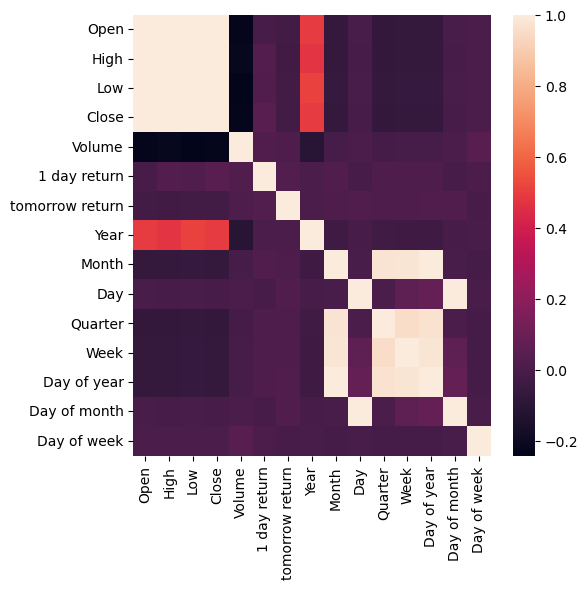

(Open, High): 1.00
(Open, Low): 1.00
(Open, Close): 1.00
(High, Low): 1.00
(High, Close): 1.00
(Low, Close): 1.00
(Month, Quarter): 0.97
(Month, Week): 0.98
(Month, Day of year): 1.00
(Day, Day of month): 1.00
(Quarter, Week): 0.95
(Quarter, Day of year): 0.97
(Week, Day of year): 0.98
{'Quarter', 'Low', 'Open', 'Day of month', 'Day of year', 'Week', 'Close', 'Day', 'Month', 'High'}
Features to drop:  {'Quarter', 'Low', 'Open', 'Day of month', 'Week', 'Month', 'High'}


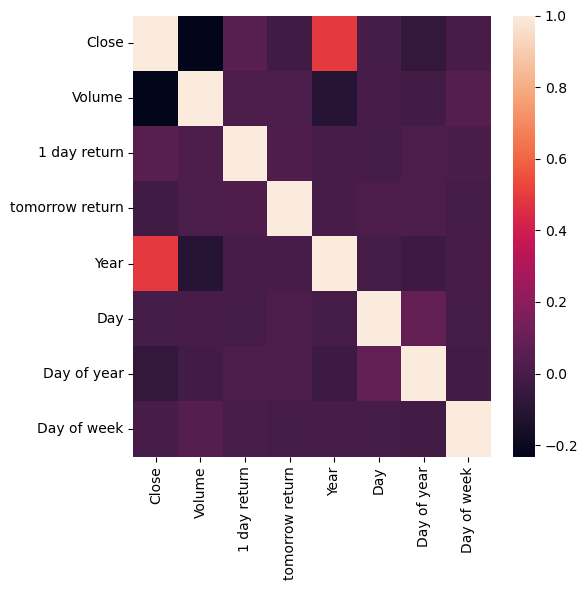

set()

In [78]:
def correlation_above_threshold(
    df: pd.DataFrame, cutoff: float = 0.95, save_path: str = None
):
    """
    Plots a heatmap of the correlation matrix and prints pairwise correlations in the format:
    (<F1>, <F2>): <Correlation>, filtered by a minimum absolute value cutoff, and finally returns a set of features to remove.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame.
    cutoff : float, optional
        The minimum absolute correlation value to display, default is 0.95

    Returns
    -------
    to_remove : set
        A set of features to remove based on correlation.
    """
    # Make figsize dependent on number of features
    num_features = len(df.columns)
    size = max(6, num_features // 3)
    fig, ax = plt.subplots(figsize=(size, size))
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix, ax=ax)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

    # Iterate through the upper triangle of the correlation matrix (ignoring the diagonal)
    to_remove = set()
    for i, f1 in enumerate(corr_matrix.columns):
        for j, f2 in enumerate(corr_matrix.columns):
            if i >= j:  # Skip lower triangle and diagonal
                continue
            r = corr_matrix.iloc[i, j]
            if abs(r) >= cutoff:
                print(f"({f1}, {f2}): {r:.2f}")
                to_remove.add(f1)
                to_remove.add(f2)

    return to_remove


duplicate = correlation_above_threshold(df, save_path="plots/correlation_basic.png")
print(duplicate)

# This part needs to be done manually to remove all except for one of the strongly correlated features
duplicate.discard("tomorrow return")
duplicate.discard("Close")
duplicate.discard("Day")
duplicate.discard("Day of year")

print("Features to drop: ", duplicate)
df.drop(duplicate, axis=1, inplace=True)

# Should print nothing and show low correlations
correlation_above_threshold(df, save_path="plots/correlation_basic_cleaned.png")

Now, we repeat this process as we reinclude the lag features, and once again for technical indicators.

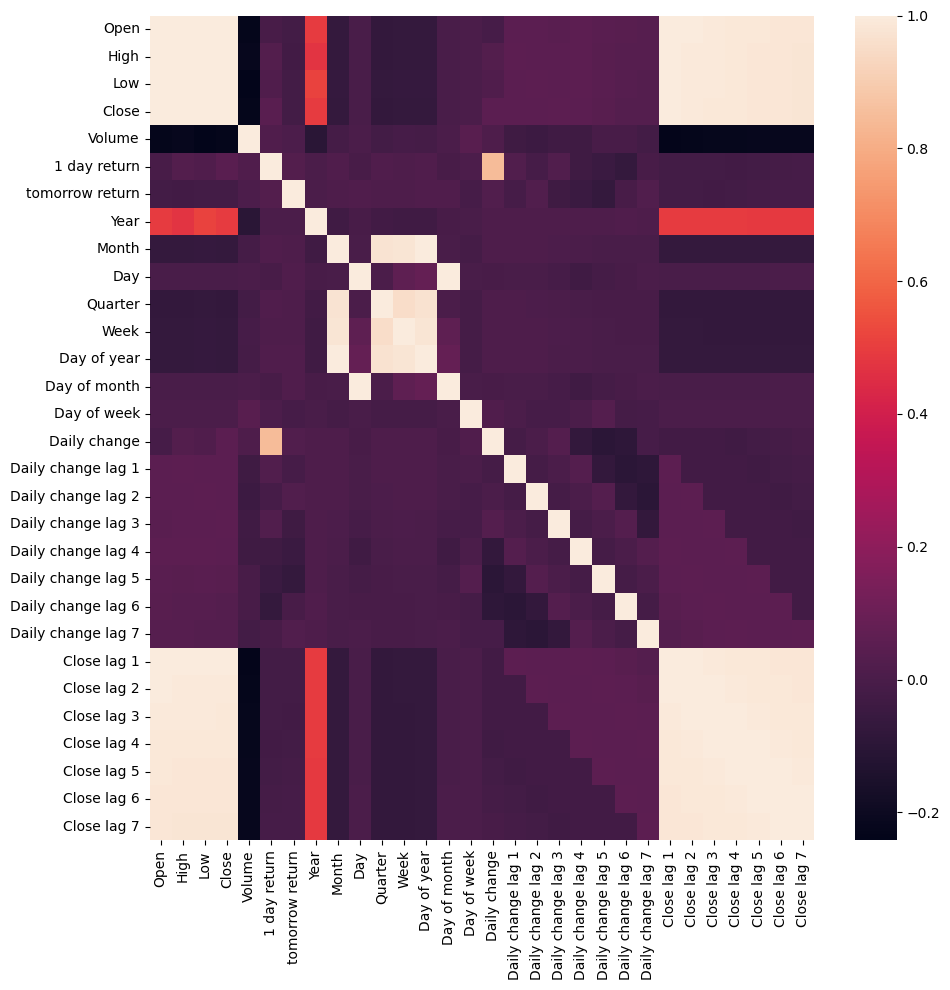

(Open, High): 1.00
(Open, Low): 1.00
(Open, Close): 1.00
(Open, Close lag 1): 1.00
(Open, Close lag 2): 1.00
(Open, Close lag 3): 0.99
(Open, Close lag 4): 0.99
(Open, Close lag 5): 0.99
(Open, Close lag 6): 0.98
(Open, Close lag 7): 0.98
(High, Low): 1.00
(High, Close): 1.00
(High, Close lag 1): 1.00
(High, Close lag 2): 0.99
(High, Close lag 3): 0.99
(High, Close lag 4): 0.99
(High, Close lag 5): 0.98
(High, Close lag 6): 0.98
(High, Close lag 7): 0.98
(Low, Close): 1.00
(Low, Close lag 1): 1.00
(Low, Close lag 2): 0.99
(Low, Close lag 3): 0.99
(Low, Close lag 4): 0.99
(Low, Close lag 5): 0.98
(Low, Close lag 6): 0.98
(Low, Close lag 7): 0.98
(Close, Close lag 1): 1.00
(Close, Close lag 2): 0.99
(Close, Close lag 3): 0.99
(Close, Close lag 4): 0.99
(Close, Close lag 5): 0.98
(Close, Close lag 6): 0.98
(Close, Close lag 7): 0.98
(Month, Quarter): 0.97
(Month, Week): 0.98
(Month, Day of year): 1.00
(Day, Day of month): 1.00
(Quarter, Week): 0.95
(Quarter, Day of year): 0.97
(Week, Day 

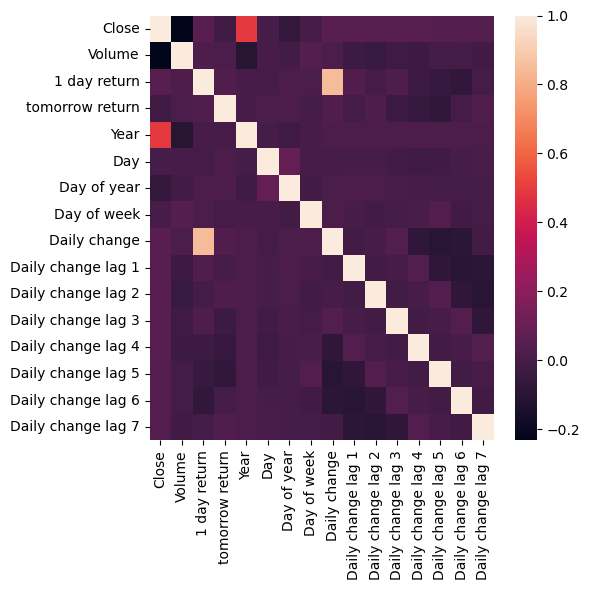

set()

In [79]:
duplicate = correlation_above_threshold(df_l, save_path="plots/correlation_lag.png")
print(duplicate)

# Again, the manual part
duplicate.discard("tomorrow return")
duplicate.discard("Close")
duplicate.discard("Day")
duplicate.discard("Day of year")

print("Features to drop: ", duplicate)
df_l.drop(duplicate, axis=1, inplace=True)

# Should print nothing and show low correlations
correlation_above_threshold(df_l, save_path="plots/correlation_lag_cleaned.png")

This time, we see that close lag X (i.e. close price from X days ago) is strongly correlated with the close price of the day and is an unnecessary feature. We repeat this for the technical indicators.

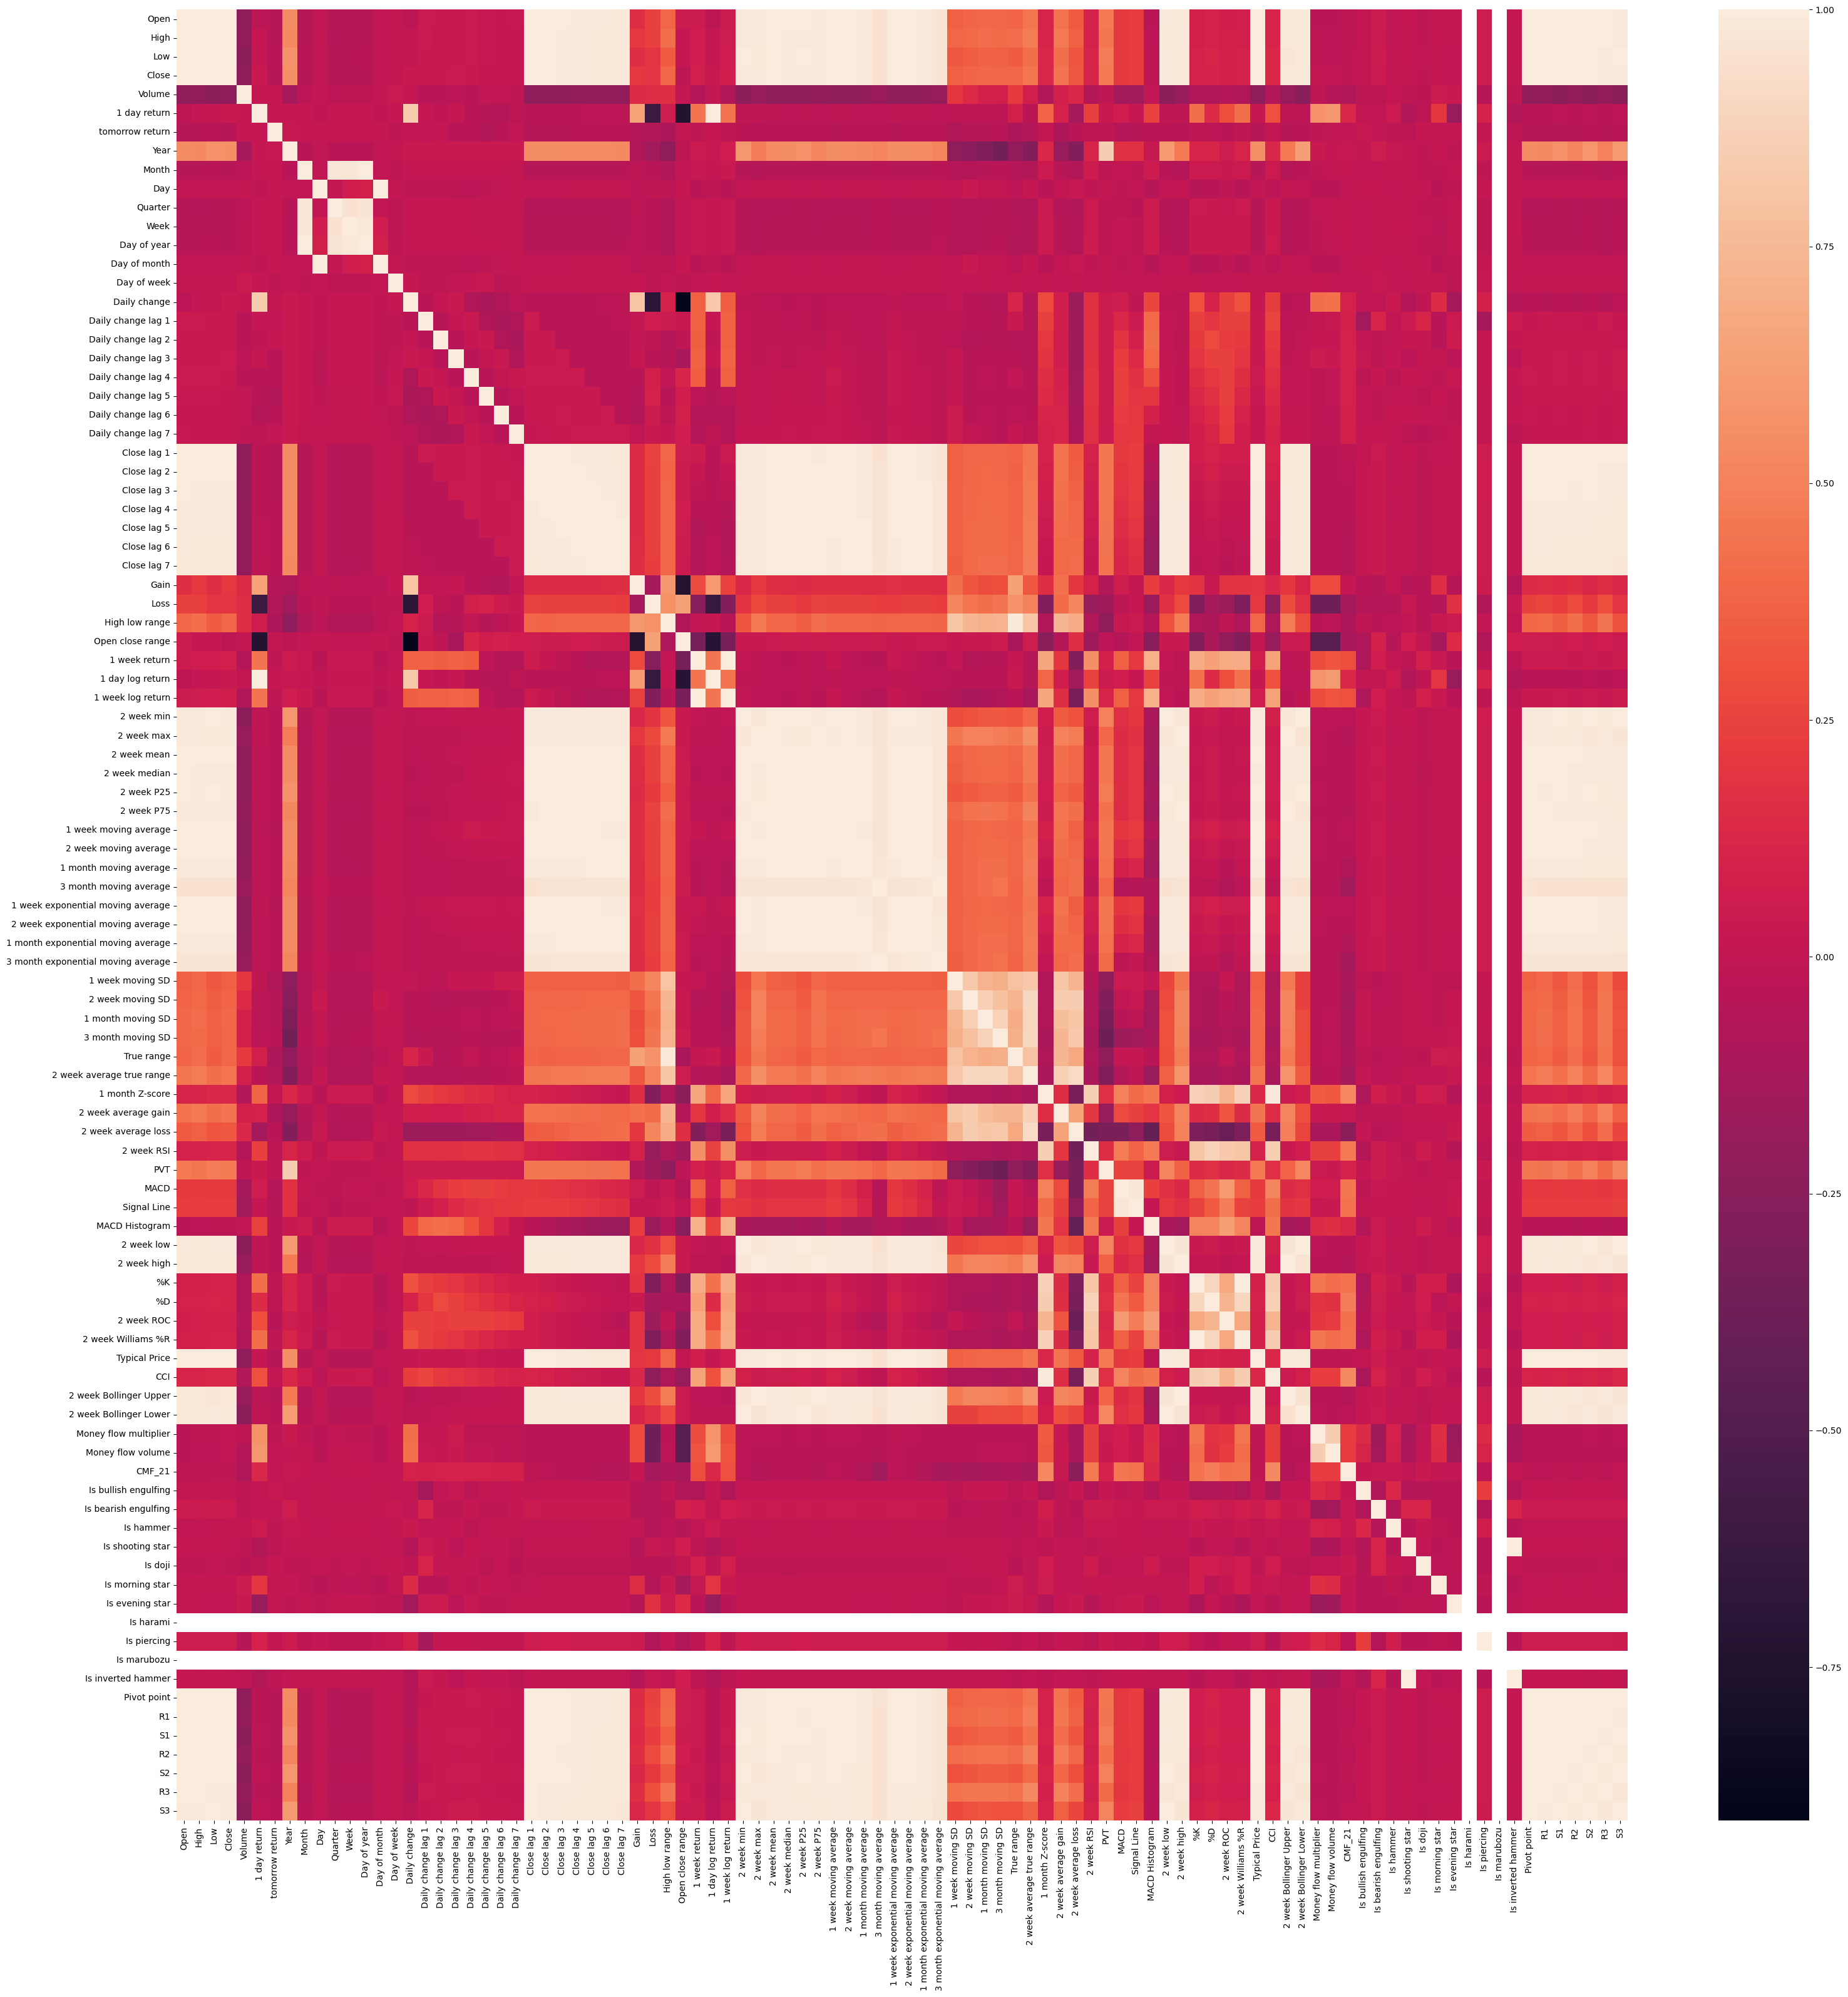

(Open, High): 1.00
(Open, Low): 1.00
(Open, Close): 1.00
(Open, Close lag 1): 1.00
(Open, Close lag 2): 1.00
(Open, Close lag 3): 0.99
(Open, Close lag 4): 0.99
(Open, Close lag 5): 0.99
(Open, Close lag 6): 0.99
(Open, Close lag 7): 0.98
(Open, 2 week min): 0.99
(Open, 2 week max): 0.99
(Open, 2 week mean): 0.99
(Open, 2 week median): 0.99
(Open, 2 week P25): 0.99
(Open, 2 week P75): 0.99
(Open, 1 week moving average): 1.00
(Open, 2 week moving average): 0.99
(Open, 1 month moving average): 0.99
(Open, 3 month moving average): 0.95
(Open, 1 week exponential moving average): 1.00
(Open, 2 week exponential moving average): 1.00
(Open, 1 month exponential moving average): 0.99
(Open, 3 month exponential moving average): 0.97
(Open, 2 week low): 0.99
(Open, 2 week high): 0.98
(Open, Typical Price): 1.00
(Open, 2 week Bollinger Upper): 0.98
(Open, 2 week Bollinger Lower): 0.98
(Open, Pivot point): 1.00
(Open, R1): 1.00
(Open, S1): 1.00
(Open, R2): 1.00
(Open, S2): 1.00
(Open, R3): 0.99
(Op

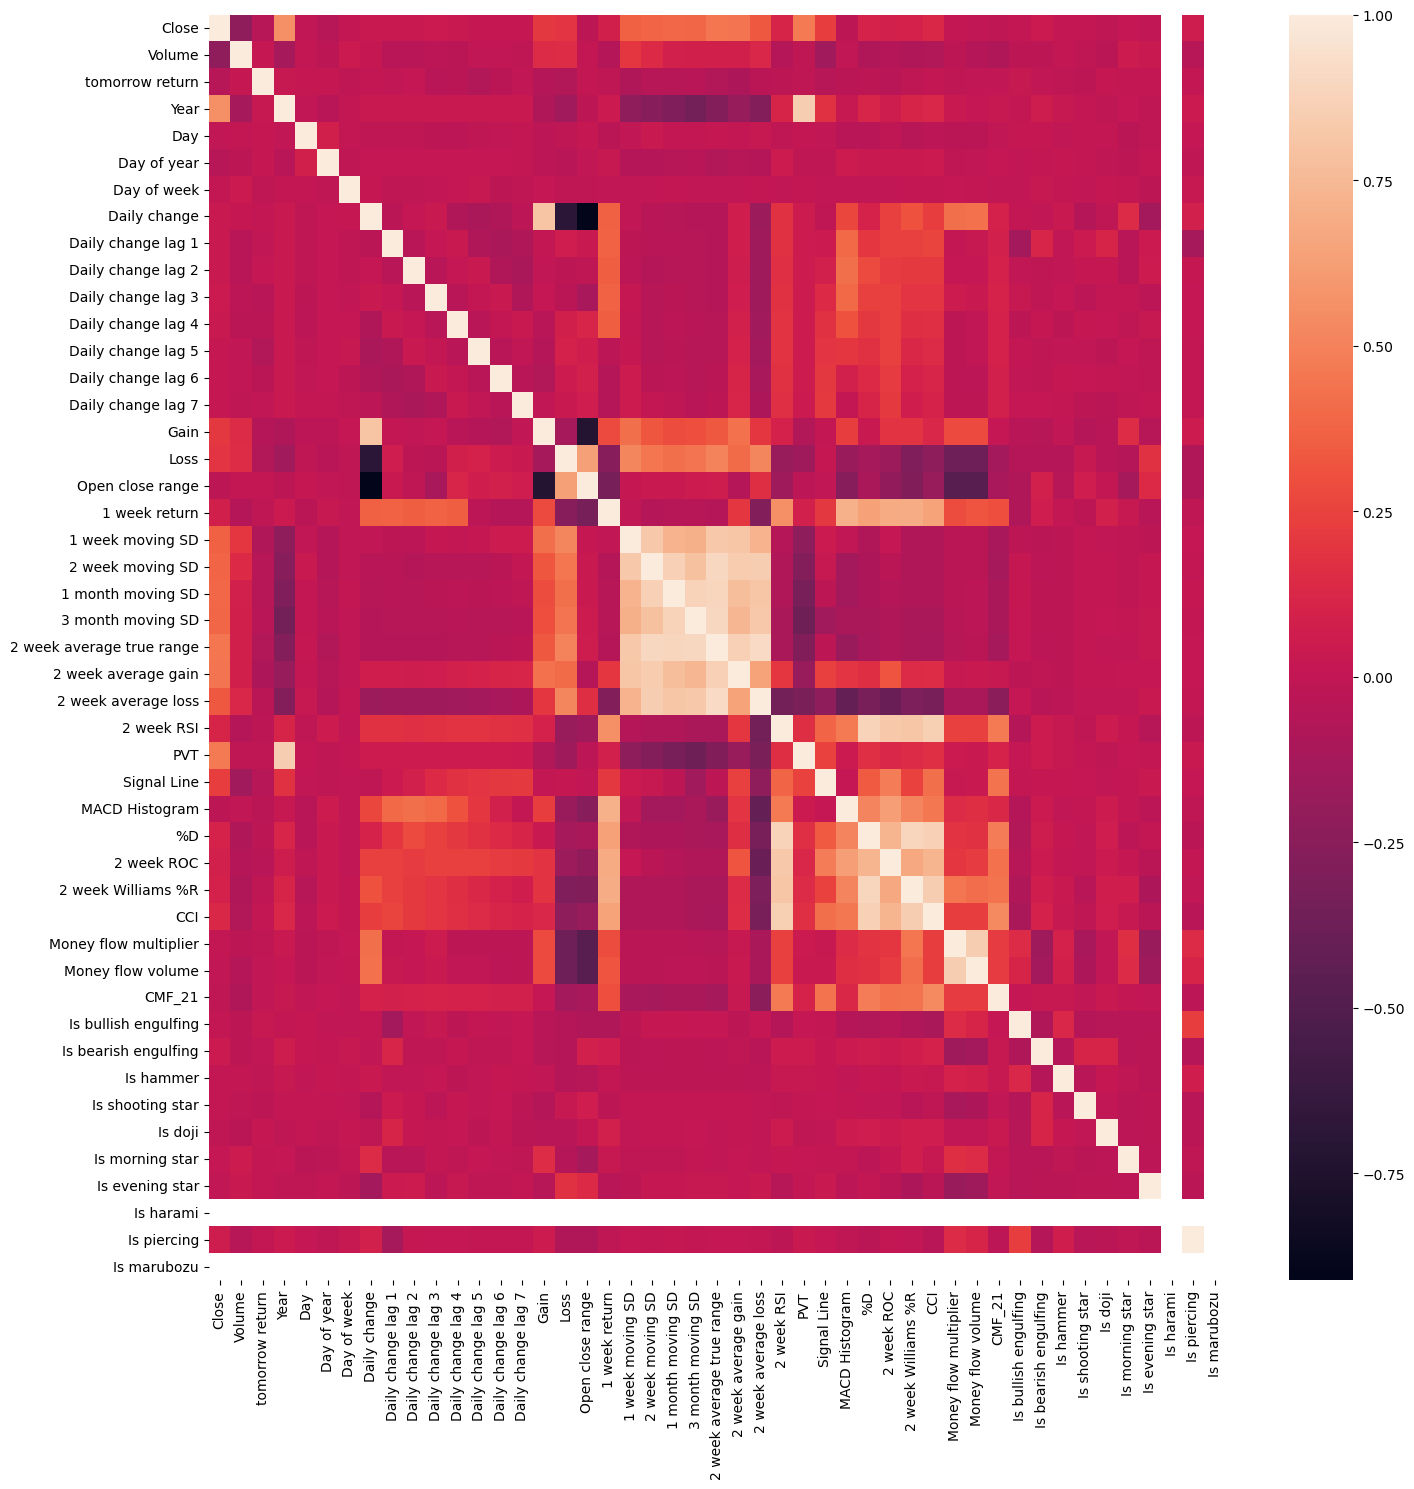

set()

In [80]:
duplicate = correlation_above_threshold(df_t, save_path="plots/correlation_technical.png")
print(duplicate)

# Again, the manual part
duplicate.discard("tomorrow return")
duplicate.discard("Close")
duplicate.discard("Day")
duplicate.discard("Day of year")
duplicate.discard("1 week return")
duplicate.discard("Signal Line")
duplicate.discard("Is shooting star")
duplicate.discard("2 week Williams %R")
duplicate.discard("CCI")

print("Features to drop: ", duplicate)
df_t.drop(duplicate, axis=1, inplace=True)

# Should print nothing and show low correlations
correlation_above_threshold(df_t, save_path="plots/correlation_technical_cleaned.png")

In [81]:
print("Basic")
print("Number of features:", len(df.columns))
print("Basic + Lag")
print("Number of features:", len(df_l.columns))
print("Basic + Lag + Technical")
print("Number of features:", len(df_t.columns))
print("Full feature list:")
print(df_t.columns)

Basic
Number of features: 8
Basic + Lag
Number of features: 16
Basic + Lag + Technical
Number of features: 47
Full feature list:
Index(['Close', 'Volume', 'tomorrow return', 'Year', 'Day', 'Day of year',
       'Day of week', 'Daily change', 'Daily change lag 1',
       'Daily change lag 2', 'Daily change lag 3', 'Daily change lag 4',
       'Daily change lag 5', 'Daily change lag 6', 'Daily change lag 7',
       'Gain', 'Loss', 'Open close range', '1 week return', '1 week moving SD',
       '2 week moving SD', '1 month moving SD', '3 month moving SD',
       '2 week average true range', '2 week average gain',
       '2 week average loss', '2 week RSI', 'PVT', 'Signal Line',
       'MACD Histogram', '%D', '2 week ROC', '2 week Williams %R', 'CCI',
       'Money flow multiplier', 'Money flow volume', 'CMF_21',
       'Is bullish engulfing', 'Is bearish engulfing', 'Is hammer',
       'Is shooting star', 'Is doji', 'Is morning star', 'Is evening star',
       'Is harami', 'Is piercing', 

We see that by removing strongly correlated features (arbitrarily defined as $|r| > 0.95$), the number of features has been reduced from 96 to 46 (again, the 47th is the label).

# Decision Tree


# kNN

# Linear and Logistic Regression

In [82]:
def run_linear_model(df: pd.DataFrame, test_size=0.3):
    """
    Runs a linear model on the given dataframe and returns the model, predictions, and actual values.

    The 'tomorrow return' column is Y, everything else is X.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to use. Must contain 'tomorrow return' column
    """

    # Split the data into train and test sets
    train_mse, test_mse, train_r2, test_r2 = [], [], [], []
    min_days = 50
    max_days = min_days + 15 * 20
    periods = np.linspace(min_days, max_days, 16, dtype=int)
    fig, ax = plt.subplots(4, 4, figsize=(15, 15))

    for i in range(16):
        period = periods[i]
        df_curr = df[-period:]

        X, Y = df_curr.drop("tomorrow return", axis=1), df_curr["tomorrow return"]
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, shuffle=False, test_size=test_size
        )

        # Model initialization
        model = LinearRegression()

        # Model training
        model.fit(X_train, Y_train)

        # Predict on train and test
        Y_train_pred = model.predict(X_train)
        Y_test_pred = model.predict(X_test)

        # Plot both predictions and actual values
        ax_i = ax[i // 4, i % 4]

        ax_i.scatter(Y_train, Y_train_pred, label="Train", s=5)
        ax_i.scatter(Y_test, Y_test_pred, label="Test", s=5)
        ax_i.set_ylabel("Predicted")
        ax_i.set_xlabel("Actual")

        ax_i.set_title(f"Linear regression on {period} days")
        ax_i.legend()

        # Calculate MSE and R^2
        train_mse.append(mean_squared_error(Y_train, Y_train_pred))
        test_mse.append(mean_squared_error(Y_test, Y_test_pred))
        train_r2.append(r2_score(Y_train, Y_train_pred))
        test_r2.append(r2_score(Y_test, Y_test_pred))

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(2, sharex=True)
    ax[0].set_title("Model performance")
    ax[0].plot(periods, train_mse, label="Train")
    ax[0].plot(periods, test_mse, label="Test")
    ax[0].set_ylabel("Mean Squared Error (MSE)")
    ax[0].legend()

    ax[1].plot(periods, train_r2, label="Train")
    ax[1].plot(periods, test_r2, label="Test")
    ax[1].set_xlabel("Days considered")
    ax[1].set_ylabel("R^2")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# run_linear_model(df_t)

We see that the performance of the linear model first improves as the number of days considered increases, with best performance occurring around 90 weekdays (18 weeks, ~4 months). This suggests that any additional information byeond 4 months ago does not meaningfully improve predictions.

This does not mean that the linear model is good! In fact, a quick inspection of the scatter plots tells us that the linear model is completely unsuitable. Observe that the distribution of the predicted values on the test set is very different from the actual values, where an ideal model is a diagonal line (i.e. prediction matching actual return), there appears to be no such trend.

The next step is to attempt logistic regression. If the exact return cannot be predicted, can we at least predict the sign of the return?

Feature coefficients for the model:
                  Feature   Coefficient
                     Gain -1.553886e+00
              Signal Line -9.783147e-01
        1 month moving SD -5.503917e-01
     Is bullish engulfing  4.585129e-01
                  Is doji  4.554578e-01
       Daily change lag 6 -3.536812e-01
       Daily change lag 3 -3.380576e-01
         2 week moving SD  2.374047e-01
          Is morning star -2.192329e-01
       Daily change lag 2  2.006952e-01
       Daily change lag 5  1.317227e-01
    Money flow multiplier -1.241514e-01
       Daily change lag 7  1.226113e-01
         Is shooting star -9.412148e-02
              Day of week -9.402354e-02
               2 week ROC -7.851703e-02
       Daily change lag 4 -5.562374e-02
                    Close  2.554773e-02
               2 week RSI -1.230011e-02
                      Day  8.118962e-03
                     Year -6.684420e-03
       2 week Williams %R  6.271349e-03
         1 week moving SD  5.866172e-03
    

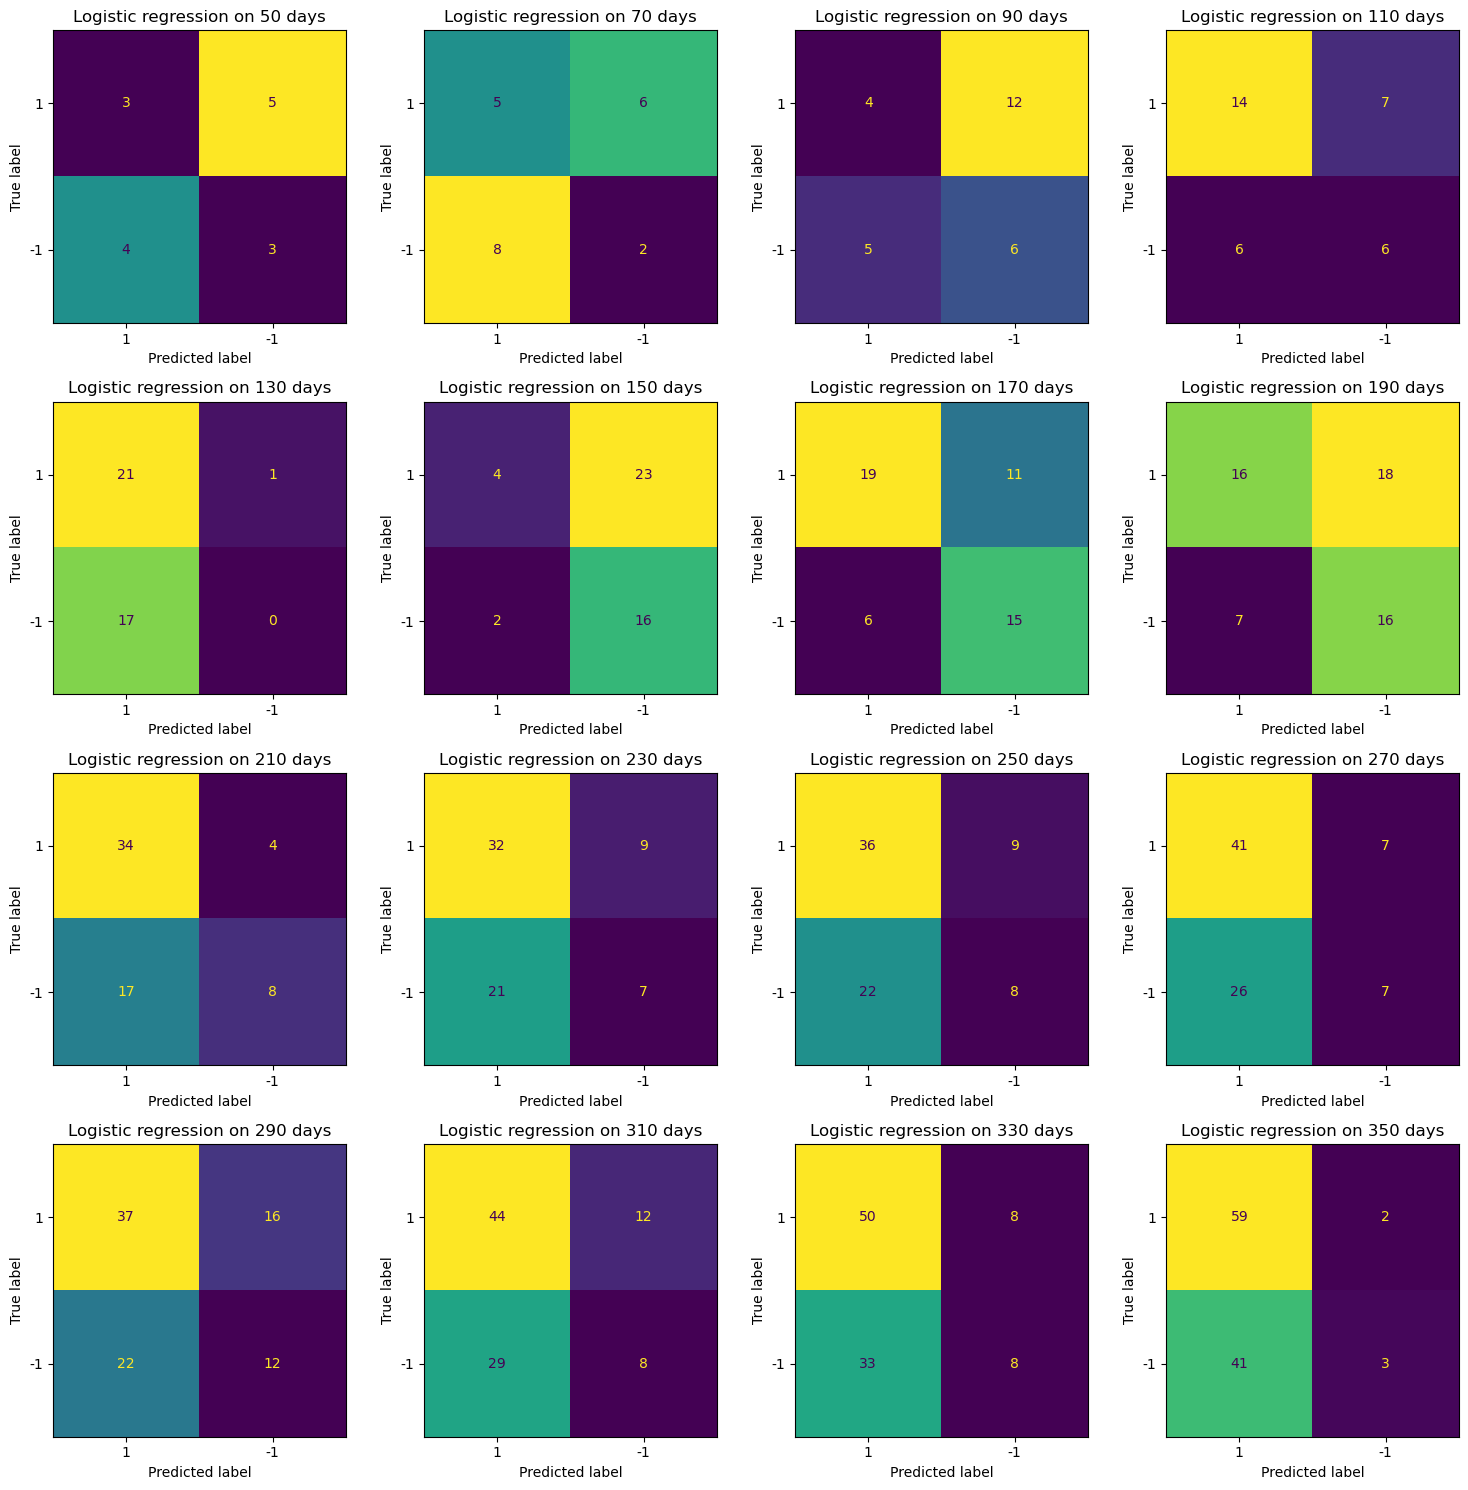

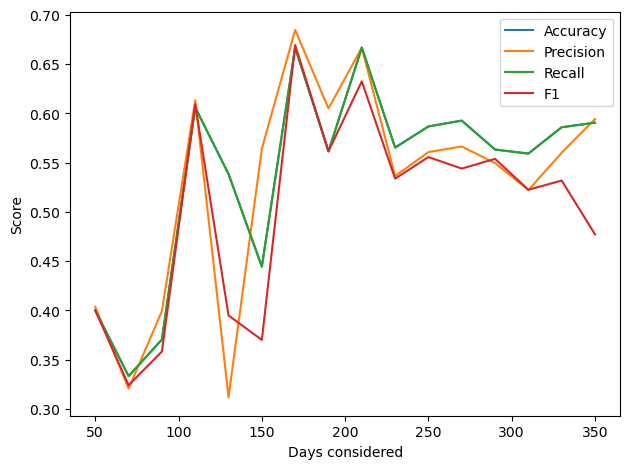

In [83]:
def run_logistic_model(df: pd.DataFrame, test_size=0.3):
    """
    Runs a logistic regression model on the given dataframe and returns performance metrics.

    The 'tomorrow return sign' column is Y, everything else is X.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to use. Must contain 'tomorrow return sign' column.
    """
    # Split the data into train and test sets
    df = df.copy()
    df["tomorrow return"] = np.sign(df["tomorrow return"])

    accuracy, precision, recall, f1 = [], [], [], []
    min_days = 50
    max_days = min_days + 15 * 20
    periods = np.linspace(min_days, max_days, 16, dtype=int)
    fig, ax = plt.subplots(4, 4, figsize=(15, 15))

    for i in range(16):
        period = periods[i]
        df_curr = df[-period:]

        X, Y = df_curr.drop("tomorrow return", axis=1), df_curr["tomorrow return"]
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, shuffle=False, test_size=test_size
        )

        # Model initialization
        model = LogisticRegression(solver="liblinear", penalty="l1", C=1, max_iter=10000)

        # Model training
        model.fit(X_train, Y_train)

        # Predict on test set
        Y_test_pred = model.predict(X_test)

        # Plot confusion matrix
        ax_i = ax[i // 4, i % 4]
        cm = confusion_matrix(Y_test, Y_test_pred, labels = [1, -1])
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=[1, -1]
        )
        disp.plot(ax=ax_i, colorbar=False)
        ax_i.set_title(f"Logistic regression on {period} days")

        # Calculate performance metrics
        accuracy.append(accuracy_score(Y_test, Y_test_pred))
        precision.append(
            precision_score(Y_test, Y_test_pred, average="weighted", zero_division=0)
        )
        recall.append(
            recall_score(Y_test, Y_test_pred, average="weighted", zero_division=0)
        )
        f1.append(f1_score(Y_test, Y_test_pred, average="weighted", zero_division=0))

        # Print coefficients for the last period
        if i == len(periods) - 1:
            print("Feature coefficients for the model:")
            coefficients = pd.DataFrame(
                {
                    "Feature": X_train.columns,
                    "Coefficient": model.coef_[0],
                }
            )
            print(
                coefficients.sort_values(
                    by="Coefficient", key=abs, ascending=False
                ).to_string(index=False)
            )

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    # Plot performance metrics over different periods
    ax.plot(periods, accuracy, label="Accuracy")
    ax.plot(periods, precision, label="Precision")
    ax.plot(periods, recall, label="Recall")
    ax.plot(periods, f1, label="F1")
    ax.set_xlabel("Days considered")
    ax.set_ylabel("Score")

    plt.tight_layout()
    plt.legend()
    plt.show()


# Example usage
run_logistic_model(df_t)

# Potential things to edit: The confusion matrix can be changed such that it will show the + 1 on top

# SVM

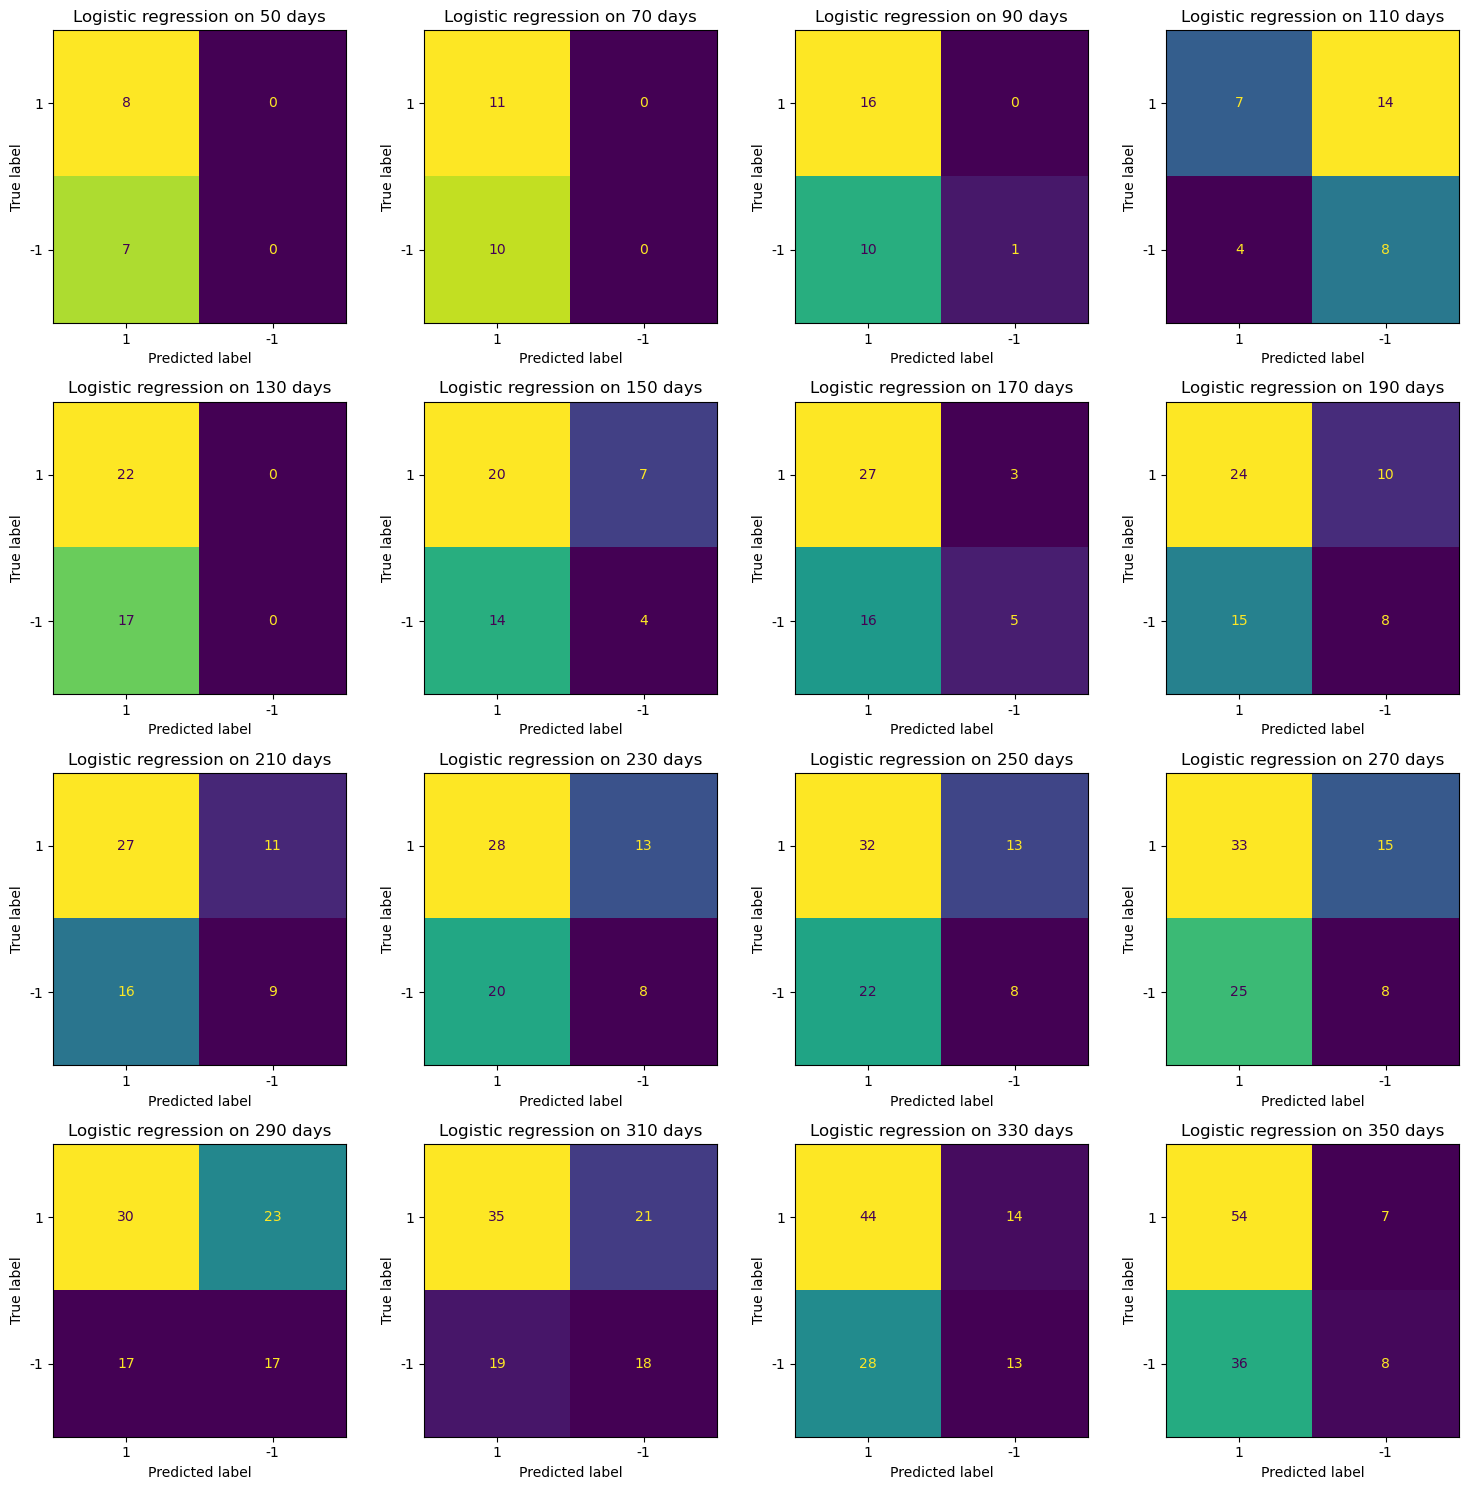

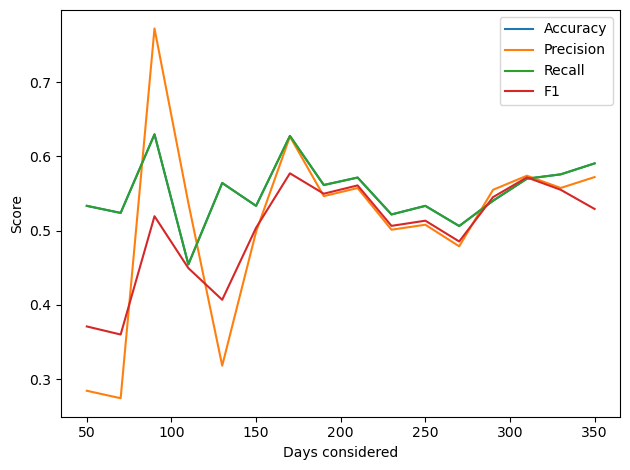

In [84]:
def run_svm_model(df: pd.DataFrame, test_size=0.3):
    """
    Runs a logistic regression model on the given dataframe and returns performance metrics.

    The 'tomorrow return sign' column is Y, everything else is X.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to use. Must contain 'tomorrow return sign' column.
    """
    # Split the data into train and test sets
    df = df.copy()
    df["tomorrow return"] = np.sign(df["tomorrow return"])

    accuracy, precision, recall, f1 = [], [], [], []
    min_days = 50
    max_days = min_days + 15 * 20
    periods = np.linspace(min_days, max_days, 16, dtype=int)
    fig, ax = plt.subplots(4, 4, figsize=(15, 15))

    for i in range(16):
        period = periods[i]
        df_curr = df[-period:]

        X, Y = df_curr.drop("tomorrow return", axis=1), df_curr["tomorrow return"]
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, shuffle=False, test_size=test_size
        )

        # Model initialization
        # model = LogisticRegression(solver="liblinear", penalty="l1", C=1, max_iter=10000)
        model = make_pipeline(StandardScaler(), SVC())
        # Model training
        model.fit(X_train, Y_train)

        # Predict on test set
        Y_test_pred = model.predict(X_test)

        # Plot confusion matrix
        ax_i = ax[i // 4, i % 4]
        cm = confusion_matrix(Y_test, Y_test_pred, labels = [1, -1])
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels= [1, -1]
        )
        disp.plot(ax=ax_i, colorbar=False)
        ax_i.set_title(f"Logistic regression on {period} days")

        # Calculate performance metrics
        accuracy.append(accuracy_score(Y_test, Y_test_pred))
        precision.append(
            precision_score(Y_test, Y_test_pred, average="weighted", zero_division=0)
        )
        recall.append(
            recall_score(Y_test, Y_test_pred, average="weighted", zero_division=0)
        )
        f1.append(f1_score(Y_test, Y_test_pred, average="weighted", zero_division=0))

        # Print coefficients for the last period
        # if i == len(periods) - 1:
        #     print("Feature coefficients for the model:")
        #     coefficients = pd.DataFrame(
        #         {
        #             "Feature": X_train.columns,
        #             "Coefficient": model.coef_[0],
        #         }
        #     )
        #     print(
        #         coefficients.sort_values(
        #             by="Coefficient", key=abs, ascending=False
        #         ).to_string(index=False)
        #     )

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    # Plot performance metrics over different periods
    ax.plot(periods, accuracy, label="Accuracy")
    ax.plot(periods, precision, label="Precision")
    ax.plot(periods, recall, label="Recall")
    ax.plot(periods, f1, label="F1")
    ax.set_xlabel("Days considered")
    ax.set_ylabel("Score")

    plt.tight_layout()
    plt.legend()
    plt.show()


# Example usage
run_svm_model(df_t)